# LineIntegralConvolution.jl

Line Integral Convolution (LIC) visualization tool for vector fields

## Usage

In [1]:
using Plots
using Random

In [2]:
using LineIntegralConvolution
greet_your_package_name()

"Hello world!"

### Electrostatic Simulation 

#### Parameters

In [14]:
## image parameters
pt_per_meter = 25  # resolution, number of pixels per meter

x_min = -10.
x_max = 10.

y_min = 2.
y_max = 13.

n_charges = 10  # number of charges to simulate

charge_value = 1e-6  # electric charge value (C)

distribution = "circle"  # "circle", "random"

SEED = 2

field_result = simulate_2d_electrostatic(
    x_min, x_max, y_min, y_max, pt_per_meter,
    n_charges, distribution, SEED, charge_value
)

(x = -10.0:0.04:10.0, y = 2.0:0.04:13.0, z = [29.272024575999602 29.302289682380632 … 29.302511929538035 29.27224637700384; 29.29343606943352 29.323862763552 … 29.324086201595044 29.293659050438517; … ; 29.29359304862489 29.324020931206924 … 29.324244378009027 29.293816038308492; 29.27218174040865 29.30244802915714 … 29.302670285028274 29.272403550047372], f = [-510.4817267597854 -512.9645372937224 … 512.982787397406 510.49990446635275; -514.4302227985906 -516.9546668419655 … 516.9732241044095 514.4487042173035; … ; -514.459312081199 -516.9840639432288 … 517.0026234767391 514.4777957453409; -510.5105713087179 -512.9936849105277 … 513.0119372500734 510.5287512262083;;; -335.1912588482547 -338.6223552396573 … -338.64768561346307 -335.21627209048773; -335.4223762861804 -338.87290992000396 … -338.8983848444957 -335.44753020234407; … ; 335.4240061562363 338.87468215462866 … 338.90015813793764 335.4491611026613; 335.1930184413268 338.6242576369062 … 338.6495890726365 335.21803271716], cx = [

#### Figures

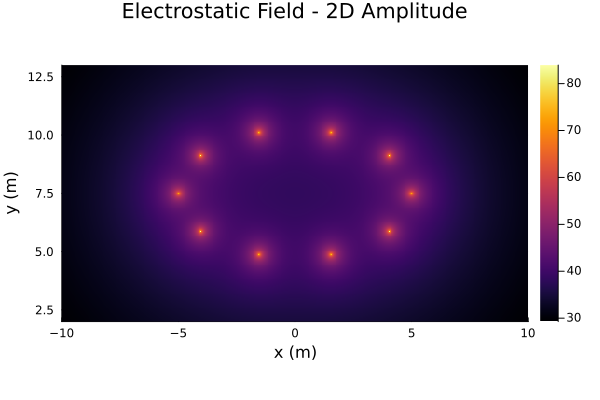

In [15]:
heatmap(
    field_result.x,
    field_result.y,
    field_result.z, 
    aspect_ratio=:equal,
    xlim=(x_min, x_max),
    ylim=(y_min, y_max)
)
title!("Electrostatic Field - 2D Amplitude")
xlabel!("x (m)")
ylabel!("y (m)")
# TODO colorbar label is missing

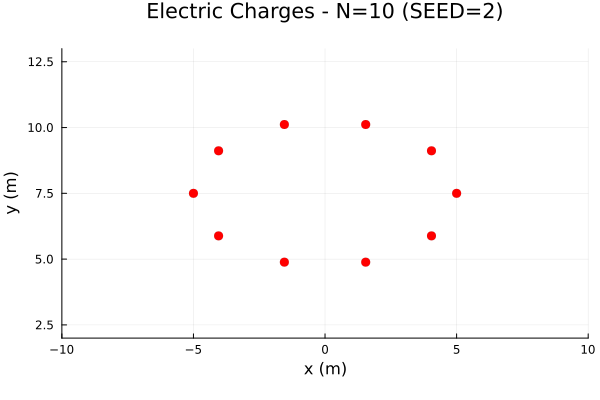

In [16]:
scatter(
    [field_result.cx], 
    [field_result.cy],
    zcolor=field_result.cq,
    legend=false, 
    markerstrokewidth=0, 
    marker=:circle, 
    markersize=5.0, 
    aspect_ratio=:equal,
    xlim=(x_min, x_max),
    ylim=(y_min, y_max),
    c=:rainbow
)
title!("Electric Charges - N=$n_charges (SEED=$SEED)")
xlabel!("x (m)")
ylabel!("y (m)")

### LIC

#### Parameters

In [ ]:
struct Field2D
    pos_x
    pos_y
    val_x
    val_y
end

function lic(SEED, kernel_size, kernel_type, f_x, f_y, f_lin)

    c_seed = SEED

    if kernel_type == "LPF"
        kernel = ones(kernel_size) / kernel_size
    elseif kernel_type == "COS"
        kernel = cos.(0.0 : pi / (2.0* kernel_size) : pi/2.0)
        kernel = kernel_cos / sum(kernel_cos)
    else
        error("Invalid kernel")
    end

    image_width = length(f_y)
    image_height = length(f_x)

    ## initial random image
    random_image = rand(MersenneTwister(c_seed), image_width, image_height) .- 0.5
    c_seed += 1

    # new images
    img = zeros(image_width, image_height)

    # compute LIC

    theta_mat = atan.(f_lin[:, :, 1], f_lin[:, :, 2])
    Δx = sin.(theta_mat)
    Δy = cos.(theta_mat)
    # abs_sin = abs.(Δx)
    # abs_cos = abs.(Δy)

    target_num_prints = 10

    for x = 1 : image_width
        for y = 1 : image_height

            if rand() > 1.0 - target_num_prints / (image_width * image_height)
                print((((x * (image_height-1) + y)/(image_width * image_height))*100), " %\n");
            end

            c_pix = random_image[x, y] * kernel[1]
            xp = x
            yp = y
            cdx = 0
            cdy = 0

            for w = 2 : kernel_size

                cdx += Δx[xp, yp]
                cdy += Δy[xp, yp]

                # compute new position pixel
                xpc = x + Int(round(cdx))
                ypc = y + Int(round(cdy))

                # check new position is valid
                if xpc < 1
                    xpc = 1
                elseif xpc > image_width
                    xpc = image_width
                end
                if ypc < 1
                    ypc = 1
                elseif ypc > image_height
                    ypc = image_height
                end

                # interpolate

                c_pix += random_image[xpc, ypc] * kernel[w]

                # norm_factor = (1 - abs_cos[xp, yp]) * (1 - abs_sin[xp, yp])
                # c_pix += random_image[xp, yp] * kernel[w] * norm_factor

                # norm_factor = abs_cos[xp, yp]
                # c_pix += random_image[xpc, yp] * kernel[w] * norm_factor

                # norm_factor = abs_sin[xp, yp]
                # c_pix += random_image[xp, ypc] * kernel[w] * norm_factor
                
                # norm_factor = abs_cos[xp, yp] * abs_sin[xp, yp]
                # c_pix += random_image[xpc, ypc] * kernel[w] * norm_factor

                xp = xpc
                yp = ypc
            end
            
            # new_image[x, y, 1] = (current_pixel2 + .5) * 0.5 + (field_log[x, y]) * 0.5
            # new_image[x, y, 2] = (current_pixel2 + .5) * 0.5 + (field_log[x, y]) * 0.5 
            # new_image[x, y, 3] = (current_pixel2 + .5) * 0.5 + (1 - field_log[x, y]) * 0.5

            img[x, y] = c_pix
        end
    end

    img .+= 0.5

    return (rnd_img=random_image, final_img=img)
end

In [ ]:
SEED = 1  # Random Seed

e_field = Field2D(
    field_result.x, 
    field_result.y,
    field_result.f[:, :, 1],
    field_result.f[:, :, 2]
)

kernel_size = 30
kernel_type = "LPF"
f_x = e_field.pos_x
f_y = e_field.pos_y
f_lin = field_result.f
img = lic(SEED, kernel_size, kernel_type, f_x, f_y, f_lin)

#### Initialization

In [ ]:
heatmap(
    field_result.x, 
    field_result.y,
    img.rnd_img,
    aspect_ratio=:equal,
    xlim=(x_min, x_max),
    ylim=(y_min, y_max)
)
title!("Initial Random Image")

#### Figures

In [ ]:
heatmap(
    field_result.x, 
    field_result.y,
    img.final_img,
    aspect_ratio=:equal,
    xlim=(x_min, x_max),
    ylim=(y_min, y_max),
    c=:grays
)
title!("LIC (LPF)")
scatter!(
    [field_result.cx], 
    [field_result.cy],
    zcolor=field_result.cq,
    legend=false, 
    markerstrokewidth=0, 
    marker=:circle, 
    markersize=5.0, 
    aspect_ratio=:equal,
    xlim=(x_min, x_max),
    ylim=(y_min, y_max),
    c=:rainbow,
    colorbar=false
)
title!("Electric Charges - N=$n_charges (SEED=$SEED)")
xlabel!("x (m)")
ylabel!("y (m)")

In [ ]:
savefig("data/electric_charges.pdf")  # export to PDF vectorial image
savefig("data/electric_charges.png")  # export to PNG